In [16]:
import os
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc['reso']='xx-hi'
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

In [17]:
CONFIGSPATH = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/src/nn/configs.json'
with open(CONFIGSPATH,'r',encoding='utf-8') as f:
    CONFIGS = json.load(f)

FILEDIR    = CONFIGS['paths']['filedir']      
MODELDIR   = CONFIGS['paths']['modeldir']    
RESULTSDIR = CONFIGS['paths']['resultsdir']  
RUNS       = CONFIGS['runs']
SPLIT      = 'valid'
PRTHRESH   = 0.01
LANDTHRESH = 0.5

In [18]:
def get_r2(ytrue,ypred,dims=None,landfrac=None,landthresh=LANDTHRESH):
    if dims is None:
        dims = list(ytrue.dims)
    if landfrac is not None:
        landmask  = landfrac>=LANDTHRESH
        oceanmask = landfrac<LANDTHRESH
        ytrueland = ytrue.where(landmask)
        ypredland = ypred.where(landmask)
        ssresland = ((ytrueland-ypredland)**2).sum(dim=dims,skipna=True)
        sstotland = ((ytrueland-ytrueland.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
        r2land = 1-(ssresland/sstotland)
        ytrueocean = ytrue.where(oceanmask)
        ypredocean = ypred.where(oceanmask)
        ssresocean = ((ytrueocean-ypredocean)**2).sum(dim=dims,skipna=True)
        sstotocean = ((ytrueocean-ytrueocean.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
        r2ocean = 1-(ssresocean/sstotocean)
        return float(r2land.values),float(r2ocean.values)
    ssres = ((ytrue-ypred)**2).sum(dim=dims,skipna=True)
    sstot = ((ytrue-ytrue.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
    r2 = 1-(ssres/sstot)
    return r2
    
def get_confusion_matrix(ytrue,ypred,dims=None,prthresh=PRTHRESH):
    if dims is None:
        dims = list(ytrue.dims)
    ytrueabove = ytrue>prthresh
    ypredabove = ypred>prthresh
    tp = (ypredabove&ytrueabove).sum(dim=dims,skipna=True).astype('float64')
    tn = (~ypredabove&~ytrueabove).sum(dim=dims,skipna=True).astype('float64')
    fp = (ypredabove&~ytrueabove).sum(dim=dims,skipna=True).astype('float64')
    fn = (~ypredabove&ytrueabove).sum(dim=dims,skipna=True).astype('float64')
    if dims==list(ytrue.dims):
        return int(tp),int(fp),int(fn),int(tn)
    else:
        return tp.astype('int64'),fp.astype('int64'),fn.astype('int64'),tn.astype('int64')

In [19]:
truepath = os.path.join(FILEDIR,f'{SPLIT}.h5')
with xr.open_dataset(truepath,engine='h5netcdf') as ds:
    truepr = ds['pr'].load()

results = {}
for run in RUNS:
    runname     = run['run_name']
    description = run.get('description',runname)
    predpath    = os.path.join(RESULTSDIR,f'nn_{runname}_norm_{SPLIT}_pr.nc')
    with xr.open_dataset(predpath,engine='h5netcdf') as ds:
        predpr = ds['predpr'].load()
    ytrue,ypred= xr.align(truepr,predpr,join='inner')
    results[runname] = dict(description=description,ytrue=ytrue,ypred=ypred)

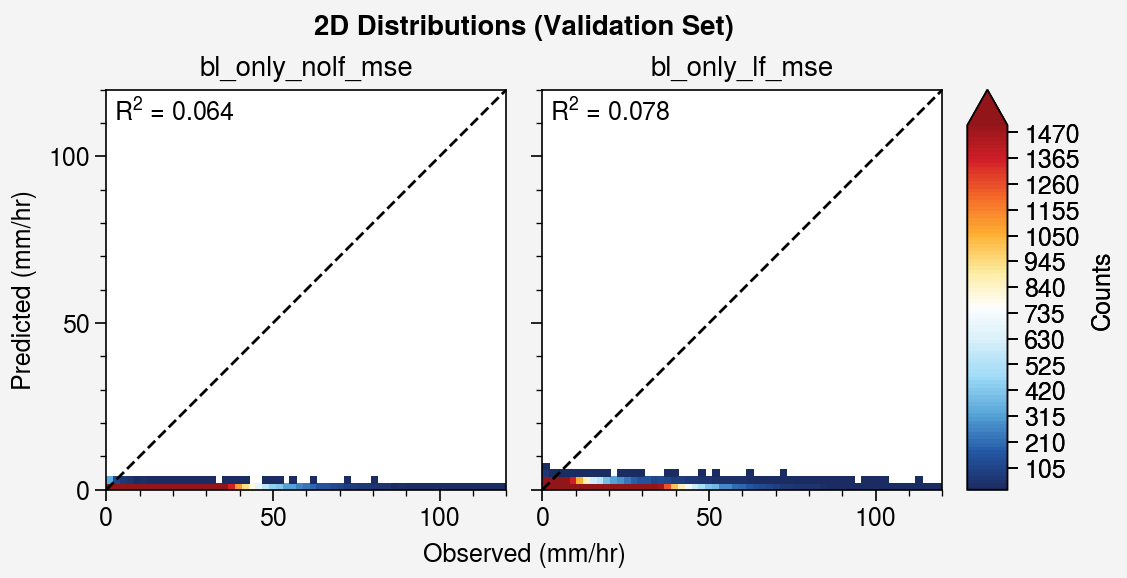

In [21]:
globalmin = 0
globalmax = 120
binedges  = np.linspace(globalmin,globalmax,60)
paneldata = []
for runname,result in results.items():
    description = result['description']
    ytrue = result['ytrue']
    ypred = result['ypred']
    r2     = get_r2(ytrue,ypred,dims=None)
    ytrueflat = ytrue.values.ravel()
    ypredflat = ypred.values.ravel()
    finite = np.isfinite(ytrueflat)&np.isfinite(ypredflat)
    hist,_,_ = np.histogram2d(ytrueflat[finite],ypredflat[finite],bins=[binedges,binedges])
    hist = np.ma.masked_where(hist==0,hist)
    paneldata.append((description,hist,float(r2)))

fig,axs = pplt.subplots(nrows=1,ncols=len(paneldata),refwidth=2,share=True)
axs.format(suptitle='2D Distributions (Validation Set)',xlabel='Observed (mm/hr)',ylabel='Predicted (mm/hr)')
im = None
for ax,(description,hist,r2) in zip(axs,paneldata):
    im = ax.pcolormesh(binedges,binedges,hist.T,cmap='ColdHot',vmin=1,vmax=1500,levels=100,extend='max')
    ax.plot([globalmin,globalmax],[globalmin,globalmax],color='k',linewidth=1,linestyle='--')
    ax.text(0.02,0.98,f'R$^2$ = {r2:.3f}',transform=ax.transAxes,va='top',ha='left')
    ax.format(title=description,xlim=(globalmin,globalmax),xticks=50,ylim=(globalmin,globalmax),yticks=50)
fig.colorbar(im,loc='r',label='Counts')
pplt.show()

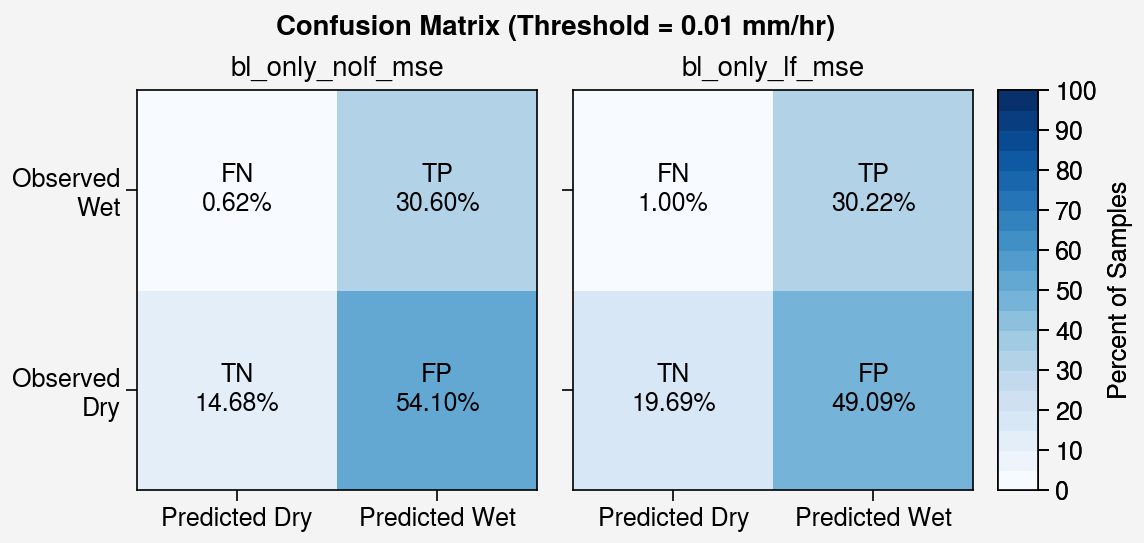

In [25]:
paneldata = []
for runname,result in results.items():
    description = result['description']
    ytrue  = result['ytrue']
    ypred  = result['ypred']
    finite = np.isfinite(ytrueflat)&np.isfinite(ypredflat)
    tp,fp,fn,tn = get_confusion_matrix(ytrue,ypred,dims=None)
    total  = tp+fp+tn+fn
    matrix = 100.0*np.array([[tn,fp],[fn,tp]],dtype=float)/total
    paneldata.append((description,matrix,dict(TP=tp,FP=fp,FN=fn,TN=tn,total=total)))

fig,axs = pplt.subplots(ncols=len(paneldata),refwidth=2,share=True)
axs.format(suptitle=f'Confusion Matrix (Threshold = {PRTHRESH} mm/hr)')
im = None
for ax,(description,matrix,count) in zip(axs,paneldata):
    edges = [0,1,2]
    im = ax.pcolormesh(edges,edges,matrix,cmap='Blues',vmin=0,vmax=100,levels=21)
    labels = [
        ('TN',count['TN'],matrix[0,0],0.5,0.5),
        ('FP',count['FP'],matrix[0,1],1.5,0.5), 
        ('FN',count['FN'],matrix[1,0],0.5,1.5), 
        ('TP',count['TP'],matrix[1,1],1.5,1.5)]
    for label,value,percent,x,y in labels:
        ax.text(x,y,f'{label}\n{percent:.2f}%',ha='center',va='center')
    ax.format(title=description,
              xlim=(0,2),xticks=[0.5,1.5],xticklabels=['Predicted Dry','Predicted Wet'],xminorticks='none',
              ylim=(0,2),yticks=[0.5,1.5],yticklabels=['Observed\nDry','Observed\nWet'],yminorticks='none')
fig.colorbar(im,loc='r',label='Percent of Samples')
pplt.show()

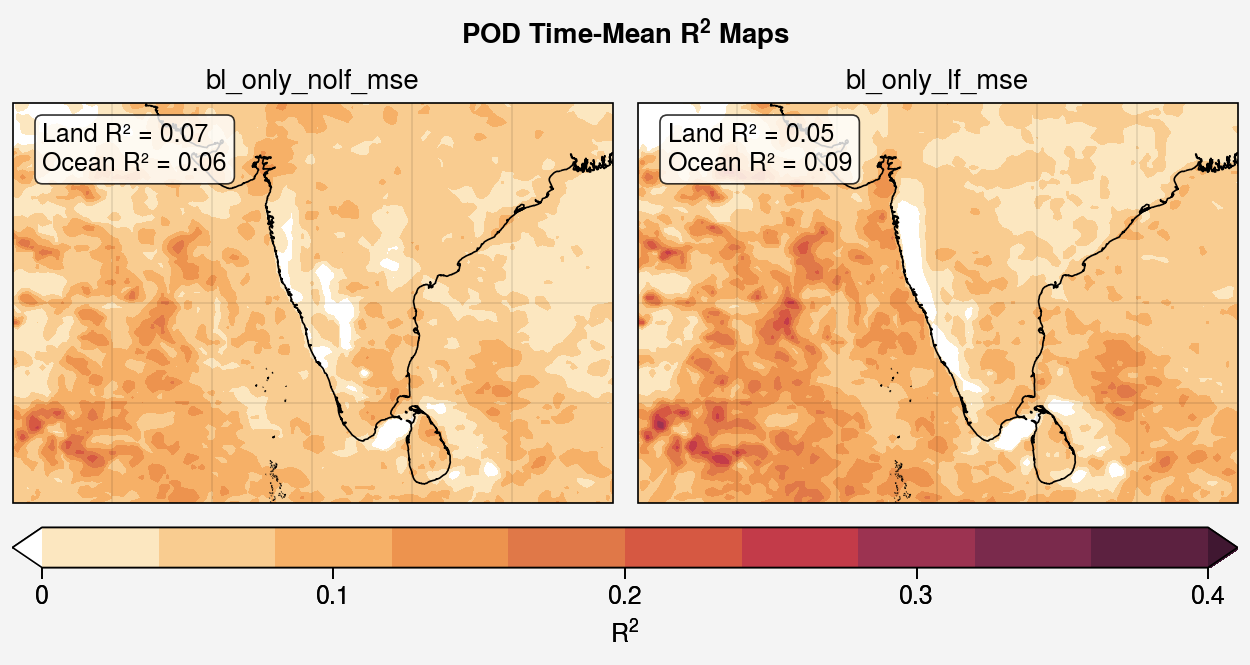

In [30]:
landfrac  = xr.open_dataarray('/global/cfs/cdirs/m4334/sferrett/monsoon-sr/data/interim/lf.nc')
paneldata = []
for runname,result in results.items():
    description = result['description']
    ytrue = result['ytrue']
    ypred = result['ypred']
    r2     = get_r2(ytrue,ypred,dims=['time'])
    r2land,r2ocean = get_r2(ytrue,ypred,dims=['time','lat','lon'],landfrac=landfrac)
    paneldata.append((description,r2,r2land,r2ocean))

fig,axs = pplt.subplots(nrows=1,ncols=len(paneldata),refwidth=3,proj='cyl',share=False)
axs.format(suptitle=f'POD Time-Mean R$^2$ Maps',coast=True,latlim=(5.,25.),latlines=[5,10,15],lonlim=(60.,90.),lonlines=5)
for i,(description,r2,r2land,r2ocean) in enumerate(paneldata):
    im = axs[i].contourf(r2.lon,r2.lat,r2,cmap='Fire',vmin=0,vmax=0.4,levels=10,extend='both')
    axs[i].text(0.05,0.95,f'Land R² = {r2land:.2f}\nOcean R² = {r2ocean:.2f}',transform=axs[i].transAxes,ha='left',va='top',
            bbox=dict(boxstyle='round',facecolor='white',alpha=0.8,edgecolor='k'))
    axs[i].format(title=description)
fig.colorbar(im,loc='b',label='R$^2$',ticks=0.1)
pplt.show()